# <center>Detecting handwritten numbers using Torch using MNIST dataset</center>

---

**<abbr title = "Modified National Institute of Standards and Technology"><u>MNIST</u></abbr> database:**
> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. - [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)


**PyTorch:**
> PyTorch is an open source machine learning framework based on the [Torch](#Torch) library, used for applications such as computer vision and natural language processing, primarily developed by Meta AI. It is free and open-source software released under the Modified BSD license. - [Wikipedia](https://en.wikipedia.org/wiki/PyTorch)


**Torch:**
> Torch is an open-source machine learning library, a scientific computing framework, and a script language based on the Lua programming language. It provides a wide range of algorithms for deep learning, and uses the scripting language LuaJIT, and an underlying C implementation. It was created at IDIAP at EPFL. As of 2018, Torch is no longer in active development. - [Wikipedia](https://en.wikipedia.org/wiki/Torch_(machine_learning)


**Convolutional Neural Network:**
> A convolutional neural network (CNN or ConvNet), is a network architecture for deep learning which learns directly from data, eliminating the need for manual feature extraction.
CNNs are particularly useful for finding patterns in images to recognize objects, faces, and scenes. They can also be quite effective for classifying non-image data such as audio, time series, and signal data.
Applications that call for object recognition and computer vision — such as self-driving vehicles and face-recognition applications — rely heavily on CNNs. - [MathWorks](https://www.mathworks.com/discovery/convolutional-neural-network-matlab.html)

## <center> Import required libraries </center>

In [1]:
import torch
import torchvision

## <center>Define hyperparameters</center>

---

1. **n_epochs:** Total number of times the dataset should be iterated over.
2. **batch_size_train:** Number of records used for training the neural network.
3. **batch_size_test:** Number of records used for testing.
4. **torch.backends.cudnn.enabled:** <abbr title = "NVIDIA® CUDA® Deep Neural Networks">cuDNN</abbr> uses nondeterministic algorithms for processing. Hence it needs to be disabled.
5. **torch.manual_seed():** Sets a manual seed for random number generation.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## <center>Load Dataset</center>

---
**Function descriptions:**
+ [`torch.utils.data.DataLoader()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
+ [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST): MNIST dataset.
+ [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose): Composes several transforms together.
+ [`torchvision.transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor): Convert a PIL Image or [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) to tensor.
+ [`torchvision.transforms.Normalize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize): Normalize a tensor image with mean and standard deviation.


The values `0.1307` and `0.3081` correspond to the global mean and standard deviation for the MNIST dataset.

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## <center>Viewing some examples</center>

---
**Function Description:**
+ [`enumerate()`](https://docs.python.org/3/library/functions.html#enumerate): The enumerate() function takes a collection (e.g. a tuple) and returns it as an enumerate object. The enumerate() function adds a counter as the key of the enumerate object.
+ `next()`: Return the next element in the iterable.


`example_data.shape` returns a Tensor consisting of 1000 examples of 28 px x 28 px greyscale(represented by the '1') images.

In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 1, 28, 28])

In [5]:
%matplotlib inline

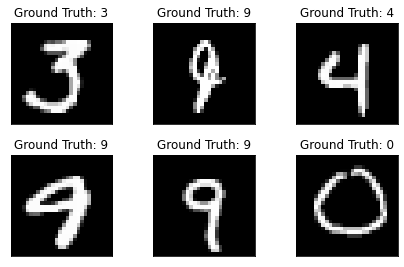

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## <center>Building the network</center>

---

**Our network is built using the following.**:
1. Two 2-D(Two-dimensional) convolutionary layers.
2. Two fully-connected(linear) layers following the convolutionary layers.
3. Rectified Linear Units(ReLU's) as an activation function.
4. Two dropout layers for regularization.

### <center>Import submodules</center>

---

**Submodule description:**
+ [`torch.nn`](https://pytorch.org/docs/stable/nn.html): These are the basic building blocks for graphs.
+ [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html): Provides important functions.
+ [`torch.optim`](https://pytorch.org/docs/stable/optim.html): `torch.optim` is a package implementing various optimization algorithms. Most commonly used methods are already supported, and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### <center>Create a class for the Neural Network</center>

---

**Function and Class description:**
+ [`torch.nn.Module()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module): Base class for all neural network modules. Your models should also subclass this class. Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes.

+ [`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d): Applies a 2D convolution over an input signal composed of several input planes.

+ [`torch.nn.Dropout2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#torch.nn.Dropout2d): Randomly zero out entire channels (a channel is a 2D feature map, e.g., the $j$-th channel of the $i$-th sample in the batched input is a 2D tensor $input[i][j]$)

+ [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear): Applies a linear transformation to the incoming data: $y = xA^T + b$

+ [`torch.nn.functional.relu()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu): Applies the rectified linear unit function element-wise.

+ [`torch.nn.functional.max_pool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html#torch.nn.functional.max_pool2d): Applies a 2D max pooling over an input signal composed of several input planes.

+ [`torch.Tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view): Returns a new tensor with the same data as the `self` tensor but of a different `shape`.

+ [`torch.nn.functional.dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.dropout.html#torch.nn.functional.dropout): During training, randomly zeroes some of the elements of the input tensor with probability `p` using samples from a Bernoulli distribution.

+ [`torch.nn.functional.log_softmax()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax): Applies a softmax followed by a logarithm. While mathematically equivalent to log(softmax(x)), doing these two operations separately is slower and numerically unstable. This function uses an alternative formulation to compute the output and gradient correctly.

+ [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD): Implements stochastic gradient descent (optionally with momentum).

+ [`torch.nn.Module.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters): Returns an iterator over module parameters. This is typically passed to an optimizer.

In [8]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
neural_network = Neural_Network()
optimizer = optim.SGD(neural_network.parameters(),lr = learning_rate, momentum = momentum)

## <center>Training the Model</center>

### <center>Variables used to keep track of the progress</center>

---

**Variable description:**
+ `train_losses`: Stores train losses.
+ `test_losses`: Stores test losses.

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### <center>Train loop</center>

---

**Function description:**
+ [`torch.nn.Module.train()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train): Sets the module in training mode. This has any effect only on certain modules.

+ [`torch.optim.Optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch.optim.Optimizer.zero_grad): Sets the gradients of all optimized `torch.Tensor`' s to zero.

+ [`torch.nn.functional.nll_loss()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html#torch.nn.functional.nll_loss): The negative log likelihood loss.

+ [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html#torch.Tensor.backward): Computes the gradient of current tensor w.r.t. graph leaves.

+ [`torch.optim.Optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step): Performs a single optimization step (parameter update).

+ [`torch.Tensor.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item): Returns the value of this tensor as a standard Python number.

In [11]:
def train(epoch):
  neural_network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = neural_network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

### <center>Test loop</center>

---

**Function description:**
+ [`torch.nn.Module.eval()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module): Sets the module in evaluation mode. This has any effect only on certain modules.

+ [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html#torch.no_grad): Context-manager that disabled gradient calculation.

In [12]:
def test():
  neural_network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = neural_network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\YASH\AppData\Local\Temp\ipykernel_17892\4204875352.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Temp\Python\WPy64-31040\python-3.10.4.amd64\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867196
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755029
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595002
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259321
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326811
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236616
Train Epoch: 1 [12160/6

### <center>Plotting training curve</center>

Text(0, 0.5, 'negative log likelihood loss')

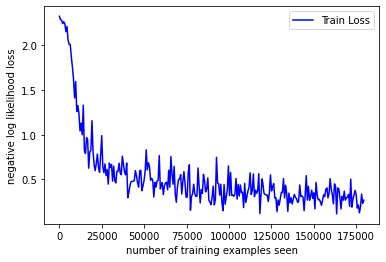

In [14]:
fig = plt.figure()

plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## <center>Predicting values</center>

In [15]:
with torch.no_grad():
  output = neural_network(example_data)

C:\Users\YASH\AppData\Local\Temp\ipykernel_17892\4204875352.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


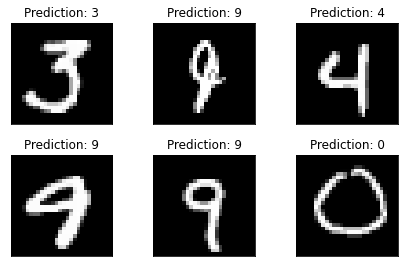

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])